In [9]:
import requests
import pandas as pd
import matplotlib.pyplot as plt
import bs4 as bs 
import io
import re

from matplotlib.ticker import FuncFormatter

#Function to convert scale in millions
def millions(x, pos):
    return '%1.1f' % (x * 1e-6)

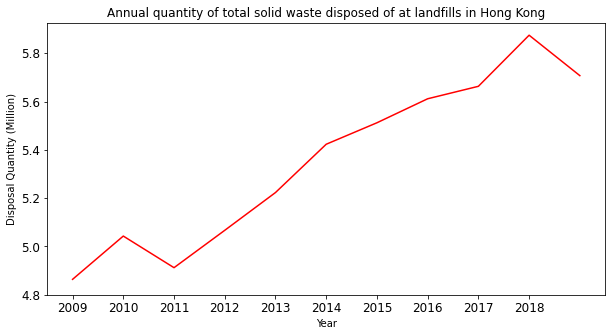

In [10]:
# Scraping figure 1

pageURLToScrape = "https://data.gov.hk/tc-data/dataset/hk-epd-statteam-solid-waste-disposal-quantity"
pageSource = requests.get(pageURLToScrape)

pageSource.encoding = 'utf-8'
soup = bs.BeautifulSoup(pageSource.content , features='html.parser')

buttonElement = soup.find('button', attrs={'class': 'p-download-option-btn p-download-btn p-primary-button btn'})
onclickAttrVal = buttonElement['onclick']

httpsLocation = onclickAttrVal.index('https')
csvLocation = onclickAttrVal.index('.csv')

#Extract the csv URL location 
csvURL = onclickAttrVal[httpsLocation : csvLocation+4]

r = requests.post(csvURL)
data = r.content.decode('utf8')
solidWasteCsvSource = pd.read_csv(io.StringIO(data))

millionFormatter = FuncFormatter(millions)

ax = solidWasteCsvSource.plot(kind='line',
                     x='year',
                     y='disposal_q',
                     title='Annual quantity of total solid waste disposed of at landfills in Hong Kong',
                     legend=False,
                     figsize=(10,5), 
                     color='Red',
                     xticks=range(2009,2019),
                     yticks=range(4800000, 6000000, 200000), 
                     fontsize=12
                    )

ax.ticklabel_format(style='plain', axis='y')
ax.set_xlabel("Year")
ax.set_ylabel("Disposal Quantity (Million)")
ax.yaxis.set_major_formatter(millionFormatter)

Text(0, 0.5, 'Number of Waste Collection Points')

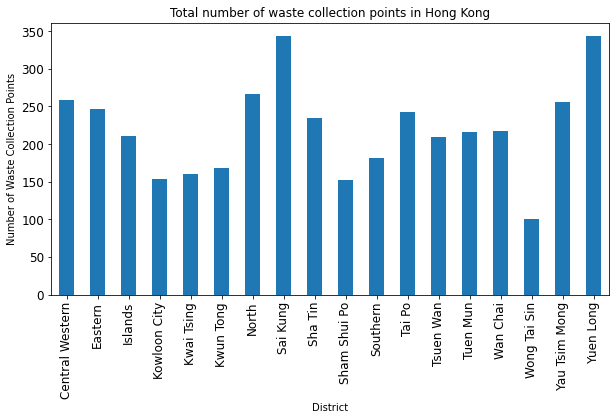

In [11]:
WasteCsvFileName = 'wasteless.csv'

WasteSource = pd.read_csv(WasteCsvFileName, encoding='utf8')

# Group by District 
groupedDF = WasteSource.groupby('district_id').count()

groupedDF.index = groupedDF.index.str.replace('_',' ')

ax = groupedDF.plot(
    kind='bar', 
    y='cp_id', 
    title ="Total number of waste collection points in Hong Kong",
    figsize=(10,5),
    legend=False, 
    fontsize=12
)

ax.set_xlabel("District")
ax.set_ylabel("Number of Waste Collection Points")

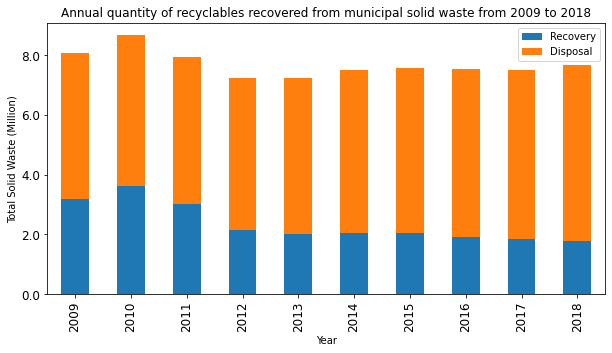

In [12]:
solidWasteRecCsvFileName = 'solid-waste-recovery-quantity-en.csv'

solidWasteRecCsvSource = pd.read_csv(solidWasteRecCsvFileName, encoding='utf8')

# Combine the excel using year to plot stacked bar chart
mergedSource = pd.merge(solidWasteRecCsvSource, solidWasteCsvSource, on='year')

ax = mergedSource.plot(
    kind="bar", 
    x='year',
    title ="Annual quantity of recyclables recovered from municipal solid waste from 2009 to 2018",
    figsize=(10,5),
    stacked=True, 
    fontsize=12)

ax.ticklabel_format(style='plain', axis='y')
ax.set_xlabel("Year")
ax.set_ylabel("Total Solid Waste (Million)")
ax.yaxis.set_major_formatter(millionFormatter)
ax.legend(["Recovery", "Disposal"]);

#mergedSource
#solidWasteCsvSource

Text(0, 0.5, 'disposal waste (kg/person/day)')

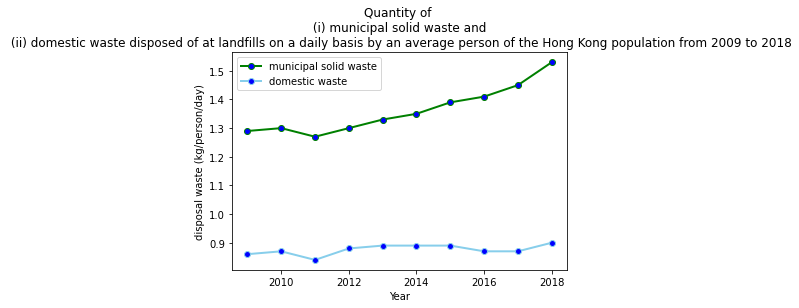

In [13]:
solidWasteDisposalRateCsvFileName = 'solid-waste-disposal-rate-en.csv'

solidWasteDisposalRate = pd.read_csv(solidWasteDisposalRateCsvFileName, encoding='utf8')

solidWasteDf = solidWasteDisposalRate.loc[solidWasteDisposalRate['waste_cat_en'] == 'Municipal solid waste']
domWasteDf = solidWasteDisposalRate.loc[solidWasteDisposalRate['waste_cat_en'] == 'Domestic waste']

fig,ax = plt.subplots(1)
plt.plot('year', 'pc_disposal_rate', data=solidWasteDf, marker='o', markerfacecolor='blue', markersize=6, color='green', linewidth=2, label="municipal solid waste")
plt.plot('year', 'pc_disposal_rate', data=domWasteDf, marker='o', markerfacecolor='blue', markersize=6, color='skyblue', linewidth=2, label="domestic waste")
plt.legend()

ax.set_title('Quantity of \n (i) municipal solid waste and \n (ii) domestic waste disposed of at landfills on a daily basis by an average person of the Hong Kong population from 2009 to 2018')
ax.set_xlabel("Year")
ax.set_ylabel("disposal waste (kg/person/day)")

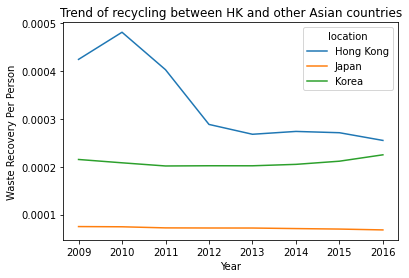

In [14]:
#Retrieve Hong Kong figures from CSV
hkRecoveredCsvFileName = 'hong-kong-waste-recovered.csv'
hkRecoveredCsvSource = pd.read_csv(hkRecoveredCsvFileName, encoding='utf8')

#Calculate ratio of waste recovered per person, assuming hong kong has a population of 7500000
hkRecoveredCsvSource["recovered"] = hkRecoveredCsvSource["recovered"] / 7500000

# Retrieve years data from the target web page
pageURL = "https://stats.oecd.org/Index.aspx?DataSetCode=MUNW#"
pageSource = requests.get(pageURL)

pageSource.encoding = 'utf-8'
soup = bs.BeautifulSoup(pageSource.content , features='html.parser')

# Define arrays to store years index from the page
years=[]
# Retrieve years of figures
for elm in soup.find_all('th', attrs={'class' : 'HDim'}):
    if elm.get_text() != '':
        years.append(elm.get_text())

#Retrieve json data from API provided from the webpage
jsonDataAPIURL = "https://stats.oecd.org/SDMX-JSON/data/MUNW/JPN+KOR.RECYCLING/all?startTime=1990&endTime=2018&dimensionAtObservation=allDimensions"

resp = requests.get(jsonDataAPIURL)
jsonData = resp.json()

#print (jsonData['dataSets'][0]['observations'])

value = 0
resetYearInd = True
yearInd = 0
country = ""
year = 0
for key in jsonData['dataSets'][0]['observations']:
    # Get the index of year from the key
    keyInfo = key.split(':')
    yearInd = int(keyInfo[2])
    
    if (key.startswith('0')):
        country = "Japan"
        #value = jsonData['dataSets'][0]['observations'][key][0]
    else:
        if resetYearInd:
            # Reset year indicator for the new country
            resetYearInd = False
            yearInd = 0
        
        country = "Korea"
    
    value = jsonData['dataSets'][0]['observations'][key][0]
    
    #Calculate ratio of waste recovered per person
    #Assuming 
    #   Japan has a population of 126500000 and;
    #   Korea has a population of 51640000
    if country == 'Japan':
        value = value / 126500000
    elif country == 'Korea':
        value = value / 51640000
    
    df = pd.DataFrame([[int(years[yearInd]), country, value]], columns=['year', 'location', 'recovered'])
    hkRecoveredCsvSource = hkRecoveredCsvSource.append(df, True)
                
    #yearInd += 1
    
hkRecoveredCsvSource.to_csv('tempOut.csv')

# Start prepare of pivot table
selected = hkRecoveredCsvSource.loc[hkRecoveredCsvSource['year'] >= 2009]
selected = selected.loc[selected['year'] <= 2016]

pivot = selected.pivot_table(values='recovered', columns='location', index='year')

fig,ax = plt.subplots(1,1)

pivot.plot(ax = ax)

ax.set_title('Trend of recycling between HK and other Asian countries')
ax.set_xlabel("Year")
ax.set_ylabel("Waste Recovery Per Person")

plt.show()

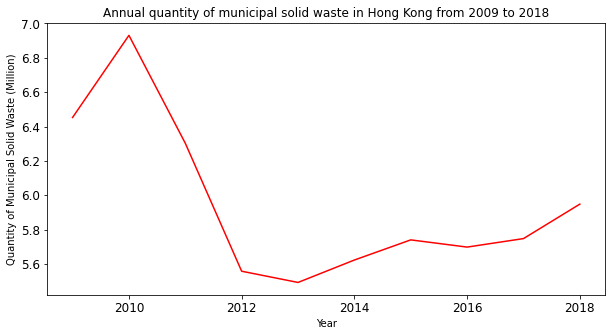

In [15]:
solidWasteGenerateRateCsvFileName = 'solid-waste-generation-quantity-en.csv'

solidWasteGenerateRateSource = pd.read_csv(solidWasteGenerateRateCsvFileName, encoding='utf8')

millionFormatter = FuncFormatter(millions)

ax = solidWasteGenerateRateSource.plot(kind='line',
                     x='year',
                     y='generation_q',
                     title='Annual quantity of municipal solid waste in Hong Kong from 2009 to 2018',
                     legend=False,
                     figsize=(10,5), 
                     color='Red',
                     fontsize=12
                    )

ax.ticklabel_format(style='plain', axis='y')
ax.set_xlabel("Year")
ax.set_ylabel("Quantity of Municipal Solid Waste (Million)")
ax.yaxis.set_major_formatter(millionFormatter)

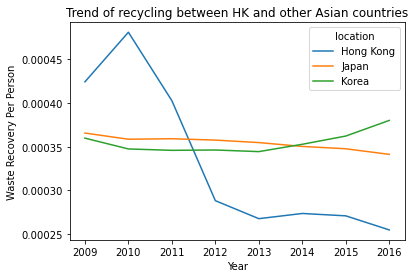

In [16]:
#Retrieve Hong Kong figures from CSV
hkRecoveredCsvFileName = 'hong-kong-waste-recovered.csv'
hkRecoveredCsvSource = pd.read_csv(hkRecoveredCsvFileName, encoding='utf8')

#Calculate ratio of waste recovered per person, assuming hong kong has a population of 7500000
hkRecoveredCsvSource["recovered"] = hkRecoveredCsvSource["recovered"] / 7500000

# Retrieve Japan and Korea figures from the target web page
pageURL = "https://stats.oecd.org/Index.aspx?DataSetCode=MUNW#"
pageSource = requests.get(pageURL)

pageSource.encoding = 'utf-8'
soup = bs.BeautifulSoup(pageSource.content , features='html.parser')

# Define arrays to store years index from the page
years=[]
# Retrieve years of figures
for elm in soup.find_all('th', attrs={'class' : 'HDim'}):
    if elm.get_text() != '':
        years.append(elm.get_text())

yearInd = 0
for tableRow in soup.find_all('tr', attrs={'class': lambda L: L and L.startswith('row')}):
    country = ""
    
    # As some country will reside in RowDimLabel2, so scrape class start with RowDimLabel
    for column in tableRow.find_all('td', attrs={'class': lambda L: L and L.startswith('RowDimLabel')}):
        if "colspan" in column.attrs:
            country = column.get_text()
    
    if (country == 'Japan' or country == 'Korea'):
        #print('Matched!' + country)
        yearInd = 0
        
        # As some country will reside in Data2, so scrape class start with Data
        for column in tableRow.find_all('td', attrs={'class': lambda L: L and L.startswith('Data')}):
            value = 0
            
            # Find the country name - country has colspan attribute
            if column.get_text() != '':
                if column.get_text() == '..':
                    value = 0
                else:
                    if column.find_next_sibling('td', attrs={'class':'FlaggedData'}) == None:
                        value = column.get_text().replace(u'\xa0', '')
                        value = value.replace('(E)', '')
                        value = value.replace('(B)', '')
                        value = value.replace('(I)', '')
                        value = value.replace('(n)', '')
                        value = int(value)
                        
                        #Calculate ratio of waste recovered per person
                        #Assuming 
                        #   Japan has a population of 126500000 and;
                        #   Korea has a population of 51640000
                        if country == 'Japan':
                            value = value / 126500000
                        elif country == 'Korea':
                            value = value / 51640000
                
                df = pd.DataFrame([[int(years[yearInd]), country, value]], columns=['year', 'location', 'recovered'])
                hkRecoveredCsvSource = hkRecoveredCsvSource.append(df, True)
                
                yearInd+=1

#hkRecoveredCsvSource.to_csv('mergeData.csv')                
                
# Start prepare of pivot table
selected = hkRecoveredCsvSource.loc[hkRecoveredCsvSource['year'] >= 2009]
selected = selected.loc[selected['year'] <= 2016]

pivot = selected.pivot_table(values='recovered', columns='location', index='year')

fig,ax = plt.subplots(1,1)

pivot.plot(ax = ax)

ax.set_title('Trend of recycling between HK and other Asian countries')
ax.set_xlabel("Year")
ax.set_ylabel("Waste Recovery Per Person")

plt.show()

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fa11ee671f0>,
      dtype=object)

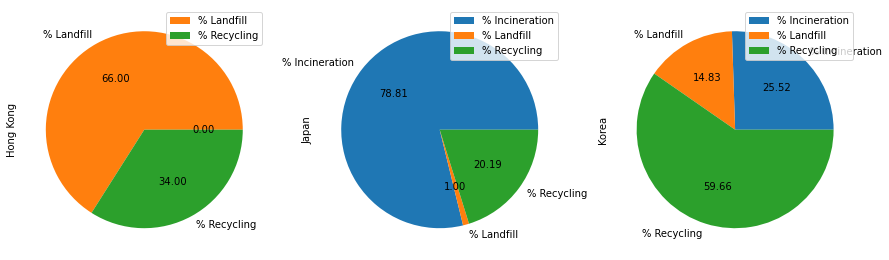

In [68]:
csvSourceFileName = 'MUNW_10122020114737782.csv'
csvSource = pd.read_csv(csvSourceFileName, encoding='utf8')

# Filter Japan and Korea figure of 2016 only for comparison
extractedDf = csvSource.loc[ ((csvSource['COU'] == 'JPN') | (csvSource['COU'] == 'KOR')) & (csvSource['YEA'] == 2016) 
                        & ((csvSource['VAR'] == 'RECYCLING_SHARE') | (csvSource['VAR'] == 'INC_SHARE') | (csvSource['VAR'] == 'LANDF_SHARE'))
                       ]

# Further extracted required column for plot
extractedDf = extractedDf[["Country", "Variable", "Value"]]

hongKongDf = pd.DataFrame([['Hong Kong', '% Recycling', 34], ['Hong Kong', '% Landfill', 66]], columns=["Country", "Variable", "Value"])
extractedDf = extractedDf.append(hongKongDf, True)
                
extractedDf = extractedDf.reset_index().groupby(['Country', 'Variable'])['Value'].aggregate('first').unstack()

extractedDf.T.plot.pie(subplots=True, figsize=(15, 10), autopct='%.2f')